<h2 align="center" style="color:purple">Phase 1: AtliQ0 Bank Credit Card Project</h2>

<h4 style="color:blue">In the Phase 1 of the project, find Target Market</h4>

### Business Problem
Objective: AtliQo Bank plans to launch a new credit card and needs to identify the most suitable customer segment based on transaction patterns and credit profiles.

Goal: Use customer, transaction, and credit profile data to identify a high-potential target group for a pilot credit card campaign.

In [2]:
#import necessary library

import sqlalchemy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import statsmodels.stats.api as sms
from urllib.parse import quote_plus
import statsmodels.api as sm
import os
import warnings
warnings.filterwarnings("ignore")

import mysql.connector
from sqlalchemy import create_engine
from dotenv import load_dotenv
from urllib.parse import quote_plus


#check the versions

print("SQLAlchemy version:", sqlalchemy.__version__)
print("Pandas version:", pd.__version__)

SQLAlchemy version: 2.0.40
Pandas version: 2.2.3


<h4 style="color:blue">Read the data from the database</h4>

In [3]:
# Load the env file
load_dotenv(dotenv_path='config.env')

# Read the credentials from .env file
user = os.getenv("MYSQL_USER")
host = os.getenv("MYSQL_HOST")
port = os.getenv("MYSQL_PORT")
database = os.getenv("MYSQL_DATABASE")

# Create SQLAlchemy engine
password = quote_plus(os.getenv("MYSQL_PASSWORD"))
engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{database}")

In [4]:
df_cp = pd.read_sql('select * from credit_profiles',con=engine)
df_cp.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


In [5]:
df_cust = pd.read_sql('select * from customers',con=engine)
df_cust.head()

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211,Married
1,2,Anjali Pandey,Female,47,City,Consultant,65172,Single
2,3,Aaryan Chauhan,Male,21,City,Freelancer,22378,Married
3,4,Rudra Bali,Male,24,Rural,Freelancer,33563,Married
4,5,Advait Malik,Male,48,City,Consultant,39406,Married


In [6]:
df_trans = pd.read_sql('select * from transactions',con=engine)
df_trans.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


<h4 style="color:blue">Explore the customer table</h4>

In [7]:
# get the column names from customer table. 

df_cust.columns

Index(['cust_id', 'name', 'gender', 'age', 'location', 'occupation',
       'annual_income', 'marital_status'],
      dtype='object')

### Dataset Information:
- cust_id: A unique identifier assigned to each customer
- name: Full name of the customer
- gender: Gender identity of the customer (Male or Female)
- age: Age of the customer, expressed in completed years
- location: Geographic location where the customer resides (categorized as City or Rural)
- occupation: Primary profession or employment type (e.g., Business Owner, Consultant, Freelancer)
- annual_income: Reported yearly income of the customer (in standard currency units)
- marital_status: Current marital status (Married or Single)

In [8]:
df_cust.describe()

,cust_id,age,annual_income
count,1000.000000,1000.000000,1000.000000
mean,500.500000,36.405000,132439.799000
std,288.819436,15.666155,113706.313793
min,1.000000,1.000000,0.000000
25%,250.750000,26.000000,42229.750000
50%,500.500000,32.000000,107275.000000
75%,750.250000,46.000000,189687.500000
max,1000.000000,135.000000,449346.000000


In [9]:
df_cust.isnull().sum()

cust_id           0
name              0
gender            0
age               0
location          0
occupation        0
annual_income     0
marital_status    0
dtype: int64

Text(0.5, 1.0, 'Annual Income of customers')

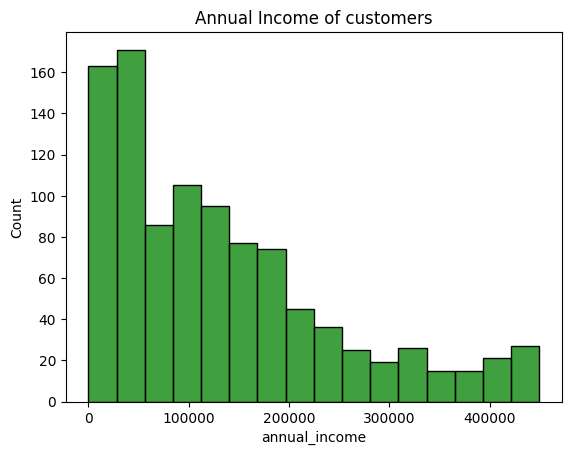

In [10]:
sns.histplot(df_cust['annual_income'],color='green',label='data')
plt.title('Annual Income of customers')

In [11]:
df_cust.iloc[[14,22,82]]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
14,15,Sanjana Malik,Female,25,Rural,Artist,0,Married
22,23,Ishan Patel,Male,19,City,Freelancer,36863,Married
82,83,Reyansh Mukherjee,Male,27,City,Freelancer,0,Single


In [12]:
int((df_cust.annual_income < 100).sum())

60

In [13]:
occ_wise_median = df_cust.groupby('occupation')['annual_income'].median()
occ_wise_median

occupation
Accountant              65265.0
Artist                  44915.0
Business Owner         254881.0
Consultant              51175.0
Data Scientist         127889.0
Freelancer              45189.5
Fullstack Developer     74457.0
Name: annual_income, dtype: float64

In [14]:
df_cust['annual_income'] = df_cust.apply(
    lambda row: occ_wise_median[row['occupation']] if row['annual_income'] < 100 else row['annual_income'],
    axis=1
)

In [15]:
avg_income_per_occupation = df_cust.groupby('occupation')['annual_income'].mean()
avg_income_per_occupation

occupation
Accountant              64123.562500
Artist                  45239.842105
Business Owner         268119.833910
Consultant              59927.257732
Data Scientist         136208.603261
Freelancer              76293.089912
Fullstack Developer     78618.385135
Name: annual_income, dtype: float64

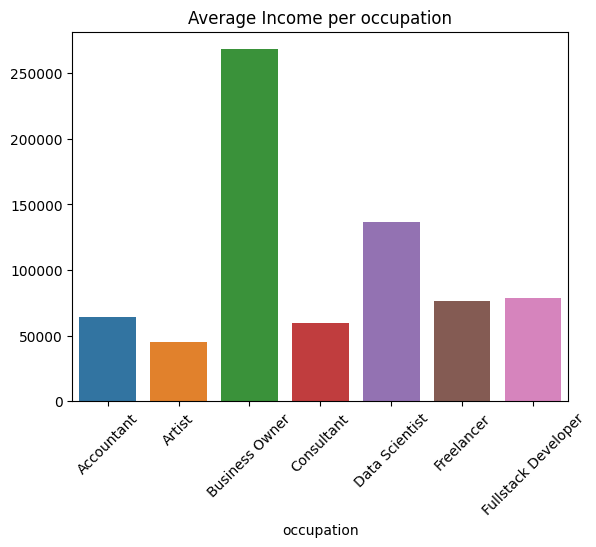

In [16]:
sns.barplot(x=avg_income_per_occupation.index,y=avg_income_per_occupation.values,palette='tab10')
plt.title('Average Income per occupation')
plt.xticks(rotation=45)
plt.show()

#### Insights:
- Business owners earn significantly more than individuals in other occupations, underscoring their dominant financial standing within the customer base.
- Data scientists also report a high average income, likely reflecting the growing market demand and specialized skillset associated with the role.
- Occupations such as fullstack developers, freelancers, consultants, and accountants fall in the middle income range, while artists represent the lowest average earners in the dataset.

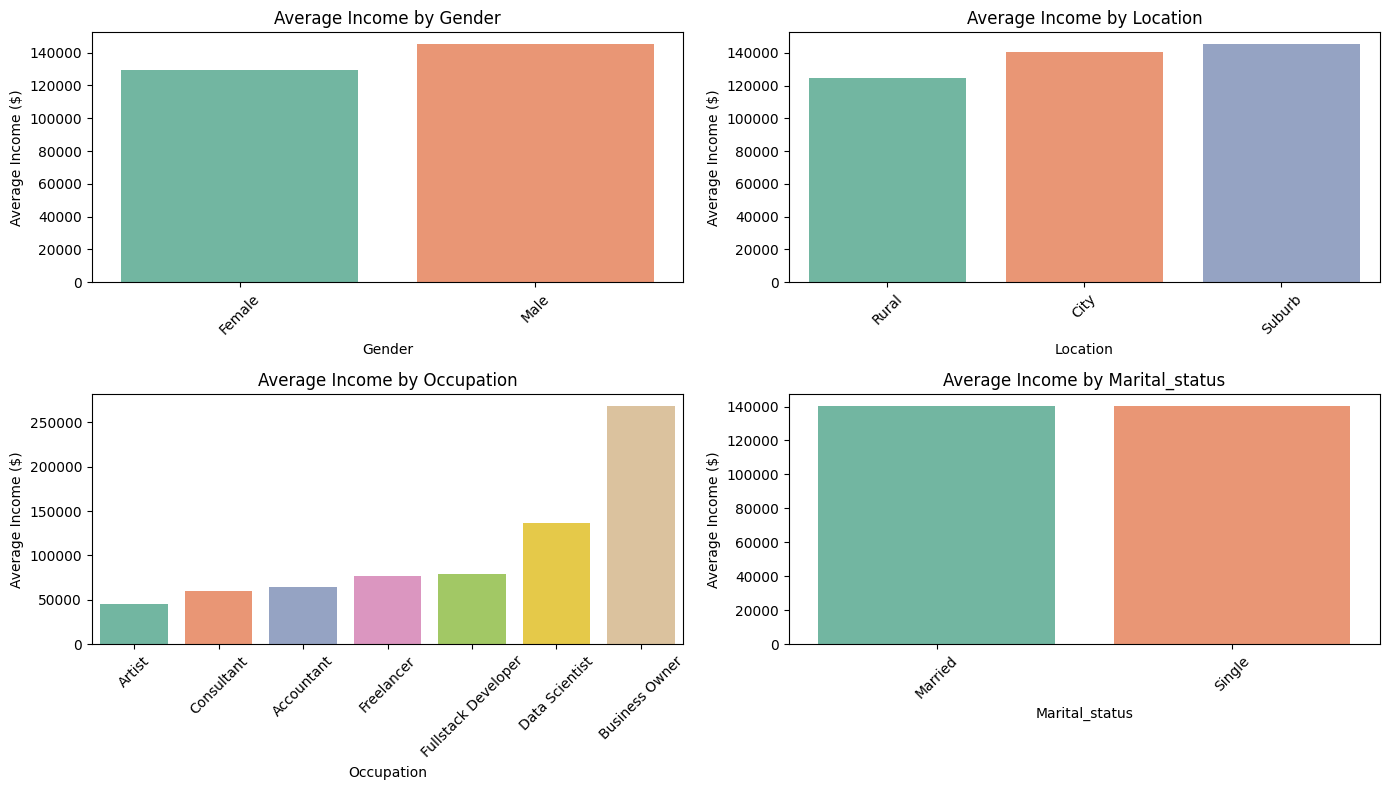

In [17]:
# Create a bar plots to visualize average annual income across each categorical variable (gender, location, occupation, marital status)

categorical_columns = ['gender', 'location', 'occupation', 'marital_status']
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    ax = axes[i]
    avg_income_per_group = df_cust.groupby(col)['annual_income'].mean().sort_values()

    sns.barplot(
        x=avg_income_per_group.index,
        y=avg_income_per_group.values,
        hue=avg_income_per_group.index,
        palette='Set2',
        legend=False,
        ax=ax
    )

    ax.set_title(f'Average Income by {col.capitalize()}')
    ax.set_xlabel(col.capitalize())
    ax.set_ylabel('Average Income ($)')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### Insights from Categorical Analysis of Average Annual Income
- Gender: Males have a slightly higher average income than females.

- Location: Customers living in city and suburban areas earn noticeably more than those in rural regions.

- Occupation: Business Owners lead significantly in average income, followed by Data Scientists.
- Occupations such as fullstack developers, freelancers, consultants, and accountants fall in the middle income range, while artists represent the lowest average earners in the dataset.

- Marital Status: Married and single customers have similar income levels, suggesting marital status has little to no impact on average earnings in this dataset.

### Analyze Age Column

In [18]:
df_cust.age.describe()

count    1000.000000
mean       36.405000
std        15.666155
min         1.000000
25%        26.000000
50%        32.000000
75%        46.000000
max       135.000000
Name: age, dtype: float64

In [19]:
df_cust[(df_cust.age > 80) | (df_cust.age < 15)]

,cust_id,name,gender,age,location,occupation,annual_income,marital_status
0,1,Manya Acharya,Female,2,City,Business Owner,358211.0,Married
41,42,Aaryan Shah,Male,110,City,Artist,7621.0,Married
165,166,Sia Dutta,Female,1,City,Freelancer,39721.0,Single
174,175,Rohan Sharma,Male,110,City,Freelancer,23723.0,Married
222,223,Arjun Batra,Male,110,Suburb,Freelancer,210987.0,Married
277,278,Aarav Tandon,Male,110,City,Consultant,96522.0,Single
295,296,Ayush Pandey,Male,1,Rural,Accountant,55254.0,Married
325,326,Virat Goel,Male,110,City,Accountant,61021.0,Single
610,611,Rehan Verma,Male,135,Rural,Business Owner,444776.0,Married
692,693,Dhruv Jha,Male,1,City,Business Owner,83045.0,Married


In [20]:
int(df_cust.age.median())

32

In [21]:
df_cust['age'] = df_cust.apply(
    lambda row: 32 if (row['age'] > 80 or row['age'] < 15) else row['age'],
    axis=1
)

In [22]:
bins = [17, 25, 48, 65]  # Upper limits for your bins
labels = ['18-25', '26-48', '49-65']

df_cust['age_group'] = pd.cut(df_cust['age'], bins=bins, labels=labels)

In [23]:
age_group_values = df_cust['age_group'].value_counts()
age_group_values

age_group
26-48    577
18-25    240
49-65    183
Name: count, dtype: int64

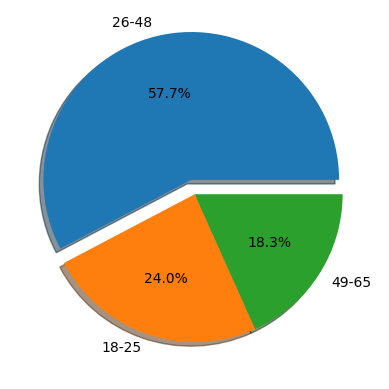

In [24]:
plt.pie(age_group_values, labels=age_group_values.index, autopct = '%1.1f%%', explode=[0.1,0,0], shadow=True)
plt.show()

#### Insights: Age Group Distribution
- Over 57% of customers fall into the 26–48 age group, representing the core customer segment.
- Around 24% of customers are in the 18–25 age bracket, suggesting a strong presence of younger.
- The 49–65 group accounts for 18% of the customer base. While smaller in proportion, they may represent a more financially stable or retirement-focused segment.

### Analyze Gender Column

In [25]:
df_cust.gender.value_counts()

gender
Male      674
Female    326
Name: count, dtype: int64

In [26]:
df_cust.location.value_counts()

location
City      683
Suburb    232
Rural      85
Name: count, dtype: int64

In [27]:
cust_locations_with_gender = df_cust.groupby(['location','gender']).size().unstack()
cust_locations_with_gender

gender,Female,Male
location,,
City,226,457
Rural,26,59
Suburb,74,158


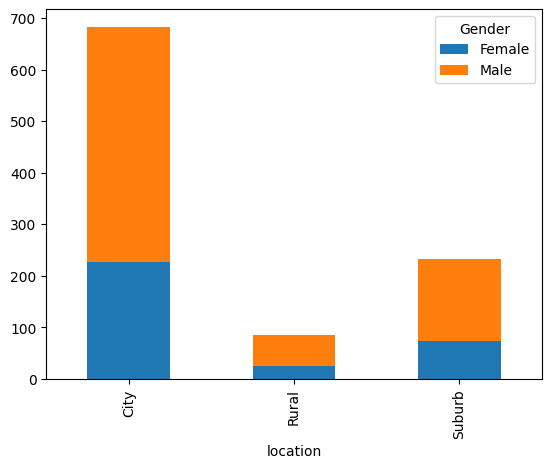

In [28]:
cust_locations_with_gender.plot(kind="bar", stacked=True)
plt.legend(title="Gender")
plt.show()

<h4 style="color:blue">Explore Credit score table</h4>

In [29]:
df_cp.columns

Index(['cust_id', 'credit_score', 'credit_utilisation', 'outstanding_debt',
       'credit_inquiries_last_6_months', 'credit_limit'],
      dtype='object')

#### Dataset Information: df_cp
- cust_id: Unique identifier assigned to each customer
- credit_score: Numerical score representing the customer's creditworthiness
- credit_utilisation: Ratio of credit used relative to the total credit limit
- outstanding_debt: Total unpaid debt currently owed by the customer (in monetary units)
- credit_inquiries_last_6_months: Number of times the customer’s credit report was pulled in the last 6 months
- credit_limit: Maximum credit amount allotted to the customer (in monetary units)

In [30]:
df_cp.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
0,1,749,0.585171,19571.0,0.0,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0
2,3,544,0.854807,513.0,4.0,1000.0
3,4,504,0.336938,224.0,2.0,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0


In [31]:
df_cp.shape

(1004, 6)

In [32]:
df_cp['cust_id'].nunique()

1000

In [33]:
df_cp[df_cp['cust_id'].duplicated(keep=False)]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
516,517,308,NaN,NaN,NaN,NaN
517,517,308,0.113860,33.0,3.0,500.0
569,569,344,NaN,NaN,NaN,NaN
570,569,344,0.112599,37.0,0.0,500.0
607,606,734,NaN,NaN,NaN,NaN
608,606,734,0.193418,4392.0,1.0,40000.0
664,662,442,NaN,NaN,NaN,NaN
665,662,442,0.856039,266.0,2.0,500.0


In [34]:
df_cs_clean_1 = df_cp.drop_duplicates(subset='cust_id',keep='last')
df_cs_clean_1.shape

(1000, 6)

In [35]:
df_cs_clean_1.isnull().sum()

cust_id                            0
credit_score                       0
credit_utilisation                 0
outstanding_debt                   0
credit_inquiries_last_6_months     0
credit_limit                      65
dtype: int64

In [36]:
df_cs_clean_1[df_cs_clean_1.credit_limit.isnull()]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit
10,11,679,0.557450,9187.0,2.0,NaN
35,36,790,0.112535,4261.0,1.0,NaN
37,38,514,0.296971,238.0,2.0,NaN
45,46,761,0.596041,24234.0,2.0,NaN
64,65,734,0.473715,13631.0,0.0,NaN
...,...,...,...,...,...,...
912,909,479,0.487555,320.0,3.0,NaN
931,928,311,0.832244,316.0,2.0,NaN
948,945,526,0.272734,227.0,1.0,NaN
954,951,513,0.175914,131.0,3.0,NaN


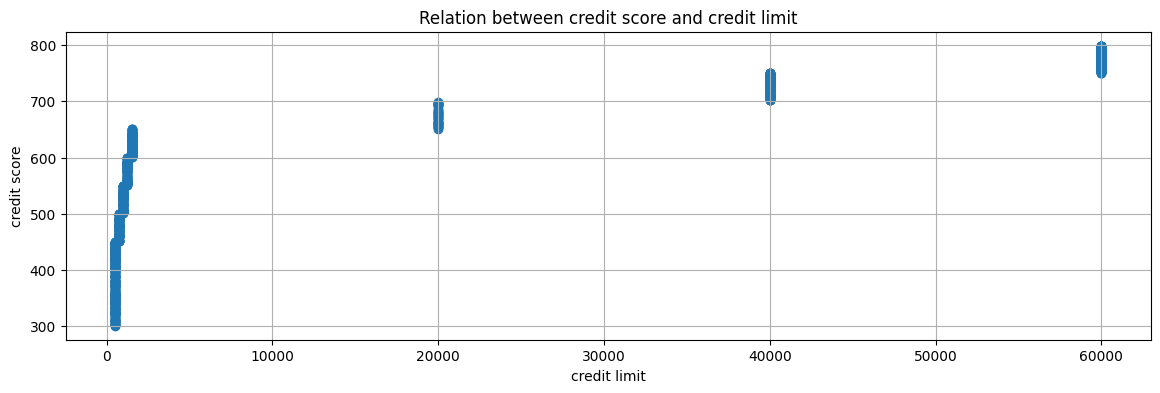

In [37]:
plt.figure(figsize=(14,4))
plt.scatter(df_cs_clean_1['credit_limit'], df_cs_clean_1['credit_score'])
plt.title('Relation between credit score and credit limit')
plt.xlabel('credit limit')
plt.ylabel('credit score')
plt.grid(True)
plt.show()

#### Insights
- Credit Scores ≤ 650: Customers in this range are generally assigned low credit limits, typically below $1,000.

- Credit Scores between 650 and 700: Customers with moderate credit scores tend to receive credit limits around $20,000.
  
- Credit Scores between 700 and 750: This segment typically qualifies for higher credit limits, averaging around $40,000.
  
- Credit Scores > 750: Customers in this top tier often receive the highest credit limits, frequently exceeding $60,000.

In [38]:
bins = [300, 450, 500, 550, 600, 650, 700, 750, 800]

labels = [f'{start}-{end-1}' for start, end in zip(bins, bins[1:])]

# Apply pd.cut
df_cs_clean_1['credit_score_range'] = pd.cut(df_cs_clean_1['credit_score'], bins=bins, labels=labels, right=False, include_lowest=True)

In [39]:
df_cs_clean_1[df_cs_clean_1['credit_score_range'] == '700-749' ].sample(3)

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range
154,155,713,0.667238,21325.0,0.0,40000.0,700-749
452,453,706,0.472699,10093.0,0.0,40000.0,700-749
176,177,717,0.836437,18794.0,3.0,40000.0,700-749


In [40]:
mode_df = df_cs_clean_1.groupby('credit_score_range')['credit_limit'].agg(lambda x: x.mode().iloc[0]).reset_index()
mode_df

,credit_score_range,credit_limit
0,300-449,500.0
1,450-499,750.0
2,500-549,1000.0
3,550-599,1250.0
4,600-649,1500.0
5,650-699,20000.0
6,700-749,40000.0
7,750-799,60000.0


In [41]:
df_cs_clean_2 = pd.merge(df_cs_clean_1, mode_df, suffixes = ("", "_mode"), on = 'credit_score_range')
df_cs_clean_2

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
0,1,749,0.585171,19571.0,0.0,40000.0,700-749,40000.0
1,2,587,0.107928,161644.0,2.0,1250.0,550-599,1250.0
2,3,544,0.854807,513.0,4.0,1000.0,500-549,1000.0
3,4,504,0.336938,224.0,2.0,1000.0,500-549,1000.0
4,5,708,0.586151,18090.0,2.0,40000.0,700-749,40000.0
...,...,...,...,...,...,...,...,...
995,996,564,0.702963,688.0,2.0,1250.0,550-599,1250.0
996,997,774,0.465462,17139.0,0.0,60000.0,750-799,60000.0
997,998,529,0.585856,386.0,3.0,1000.0,500-549,1000.0
998,999,725,0.249670,6973.0,2.0,40000.0,700-749,40000.0


In [42]:
df_cs_clean_3 = df_cs_clean_2.copy()

In [43]:
df_cs_clean_3['credit_limit'].fillna(df_cs_clean_3['credit_limit_mode'], inplace = True)

In [44]:
df_cs_clean_3.shape

(1000, 8)

In [45]:
df_cs_clean_3.isnull().sum()

cust_id                           0
credit_score                      0
credit_utilisation                0
outstanding_debt                  0
credit_inquiries_last_6_months    0
credit_limit                      0
credit_score_range                0
credit_limit_mode                 0
dtype: int64

In [46]:
df_cs_clean_3.describe()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_limit_mode
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,589.182000,0.498950,9683.597000,1.955000,19733.75000,19912.500000
std,288.819436,152.284929,0.233139,25255.893671,1.414559,24717.43818,24840.914633
min,1.000000,300.000000,0.103761,33.000000,0.000000,500.00000,500.000000
25%,250.750000,460.000000,0.293917,221.000000,1.000000,750.00000,750.000000
50%,500.500000,601.500000,0.487422,550.000000,2.000000,1500.00000,1500.000000
75%,750.250000,738.000000,0.697829,11819.500000,3.000000,40000.00000,40000.000000
max,1000.000000,799.000000,0.899648,209901.000000,4.000000,60000.00000,60000.000000


#### Insights:
Observing the minimum and maximum values for various columns reveals that the maximum value of outstanding_debt is greater than the maximum value of credit_limit. Based on business understanding, the maximum debt a customer can have is equal to the credit limit, as spending beyond the credit limit is not allowed.

In [47]:
df_cs_clean_3[df_cs_clean_3['outstanding_debt']>df_cs_clean_3['credit_limit']]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode
1,2,587,0.107928,161644.0,2.0,1250.0,550-599,1250.0
19,20,647,0.439132,205014.0,3.0,1500.0,600-649,1500.0
25,26,758,0.250811,190838.0,2.0,60000.0,750-799,60000.0
38,39,734,0.573023,122758.0,3.0,40000.0,700-749,40000.0
93,94,737,0.739948,137058.0,2.0,40000.0,700-749,40000.0
204,205,303,0.364360,187849.0,0.0,500.0,300-449,500.0
271,272,703,0.446886,154568.0,1.0,40000.0,700-749,40000.0
301,302,722,0.608076,122402.0,4.0,40000.0,700-749,40000.0
330,331,799,0.363420,208898.0,4.0,60000.0,750-799,60000.0
350,351,320,0.285081,150860.0,0.0,500.0,300-449,500.0


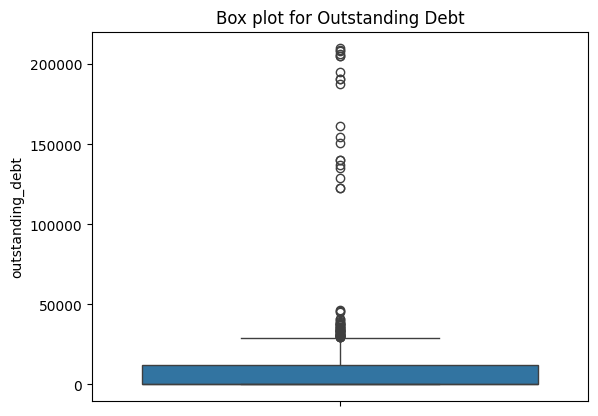

In [48]:
# Create a box plot for the outstanding_debt column
sns.boxplot(df_cs_clean_3.outstanding_debt)
plt.title('Box plot for Outstanding Debt')
plt.show()

#### Insights:
- There are several outliers with debts ranging from just above 50,000 to over 200,000, indicating that a small number of customers have exceptionally high outstanding debts.
- The box plot shows that the majority of customers have relatively low outstanding debts, with the interquartile range (IQR) and whiskers showing the spread of the bulk of the data.
- This visualization helps identify the typical range of outstanding debts and highlights the presence of significant outliers in the dataset.Instead of using any statistical approach (such as standard deviation or IQR),using business knowledge, any outstanding debt greater than the credit limit will be marked as an outlier.

In [49]:
df_cs_clean_3.loc[df_cs_clean_3['outstanding_debt']>df_cs_clean_3['credit_limit'], 'outstanding_debt'] = df_cs_clean_3['credit_limit']

In [50]:
df_cs_clean_3[df_cs_clean_3['outstanding_debt']>df_cs_clean_3['credit_limit']]

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode


### Correlation among Credit Profile variables

In [51]:
df_merged = df_cs_clean_3.merge(df_cust, on = 'cust_id', how = 'inner')
df_merged.head()

,cust_id,credit_score,credit_utilisation,outstanding_debt,credit_inquiries_last_6_months,credit_limit,credit_score_range,credit_limit_mode,name,gender,age,location,occupation,annual_income,marital_status,age_group
0,1,749,0.585171,19571.0,0.0,40000.0,700-749,40000.0,Manya Acharya,Female,32,City,Business Owner,358211.0,Married,26-48
1,2,587,0.107928,1250.0,2.0,1250.0,550-599,1250.0,Anjali Pandey,Female,47,City,Consultant,65172.0,Single,26-48
2,3,544,0.854807,513.0,4.0,1000.0,500-549,1000.0,Aaryan Chauhan,Male,21,City,Freelancer,22378.0,Married,18-25
3,4,504,0.336938,224.0,2.0,1000.0,500-549,1000.0,Rudra Bali,Male,24,Rural,Freelancer,33563.0,Married,18-25
4,5,708,0.586151,18090.0,2.0,40000.0,700-749,40000.0,Advait Malik,Male,48,City,Consultant,39406.0,Married,26-48


In [52]:
numerical_columns = ['credit_score', 'credit_utilisation', 'outstanding_debt', 'credit_limit', 'annual_income', 'age']

In [53]:
correlation_matrix = df_merged[numerical_columns].corr()
correlation_matrix

,credit_score,credit_utilisation,outstanding_debt,credit_limit,annual_income,age
credit_score,1.000000,-0.070445,0.680654,0.847952,0.575685,0.439237
credit_utilisation,-0.070445,1.000000,0.192838,-0.080493,-0.086816,-0.017185
outstanding_debt,0.680654,0.192838,1.000000,0.810581,0.555077,0.444198
credit_limit,0.847952,-0.080493,0.810581,1.000000,0.684627,0.504766
annual_income,0.575685,-0.086816,0.555077,0.684627,1.000000,0.610175
age,0.439237,-0.017185,0.444198,0.504766,0.610175,1.000000


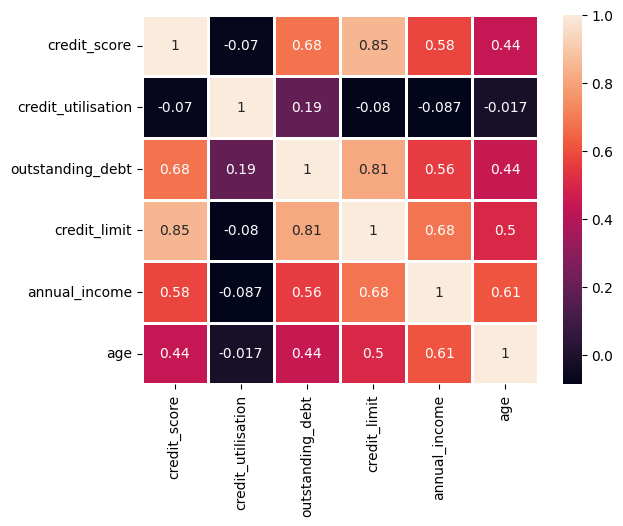

In [54]:
sns.heatmap(correlation_matrix, fmt='.2g', linewidths=1, linecolor='white', annot=True,)
plt.show()

#### Insights:
- Credit Score and Credit Limit: A strong positive correlation (0.85) indicates that customers with higher credit scores are typically granted higher credit limits.
- Outstanding Debt and Credit Limit: The high correlation (0.81) suggests that individuals with larger credit limits often carry higher levels of outstanding debt.
- Credit Score and Outstanding Debt: A moderate positive correlation (0.68) implies that customers with higher credit scores also tend to manage higher amounts of debt, potentially reflecting stronger creditworthiness.
- Annual Income and Age: With a correlation of 0.62, this relationship shows that older customers generally report higher annual incomes.
- credit_utilisation shows negligible or slightly negative correlation with all other variables, suggesting that it behaves independently and may reflect individual credit usage patterns rather than financial strength.

<h4 style="color:blue">Explore Transaction table</h4>

In [55]:
df_trans.columns

Index(['tran_id', 'cust_id', 'tran_date', 'tran_amount', 'platform',
       'product_category', 'payment_type'],
      dtype='object')

#### Dataset Information: df_transactions
- tran_id: Unique identifier for each transaction record
- cust_id: Identifier linking the transaction to a specific customer
- tran_date: Date on which the transaction was executed
- tran_amount: Monetary value of the transaction
- platform: E-commerce platform where the transaction occurred (e.g., Flipkart, Amazon, Shopify, Alibaba)
- product_category: Category of the purchased product (e.g., Electronics, Fashion & Apparel, Sports)
- payment_type: Mode of payment used for the transaction (e.g., PhonePe, Credit Card, GPay, Net Banking)

In [56]:
print(df_trans.shape)

(500000, 7)


In [57]:
df_trans.isnull().sum()

tran_id                0
cust_id                0
tran_date              0
tran_amount            0
platform            4941
product_category       0
payment_type           0
dtype: int64

In [58]:
df_trans.sample(3)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
185269,185270,30,2023-04-02,36,Alibaba,Garden & Outdoor,Net Banking
481430,481431,783,2023-08-27,672,Amazon,Electronics,Debit Card
313019,313020,174,2023-06-05,115,Flipkart,Fashion & Apparel,Debit Card


In [59]:
df_trans['platform'].value_counts()

platform
Amazon      151443
Flipkart    122660
Alibaba      73584
Meesho       73271
Shopify      39416
Cred         24741
Ebay          9944
Name: count, dtype: int64

In [60]:
df_trans['product_category'].value_counts()

product_category
Electronics               134535
Fashion & Apparel         116892
Kitchen Appliances         57353
Beauty & Personal Care     56065
Sports                     49704
Home Decor                 38355
Garden & Outdoor           23644
Books                      13635
Toys & Games                9817
Name: count, dtype: int64

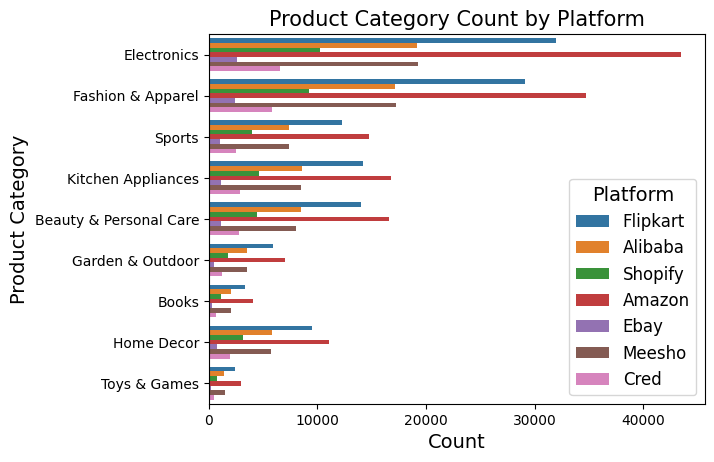

In [61]:
# Create a count plot of product_category with a hue of platform
sns.countplot(y="product_category", hue="platform", data=df_trans)
plt.title('Product Category Count by Platform', fontsize=15)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Product Category', fontsize=14)

plt.legend(title='Platform', fontsize=12, title_fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### Insights
- Amazon emerges as the most frequently used platform across all product categories, with particularly strong dominance in Electronics, Fashion & Apparel, and Kitchen Appliances.

- While Amazon leads overall, platforms such as Flipkart, Alibaba, and Shopify also show notable activity in specific categories. For example, Flipkart is actively used in Fashion & Apparel and Kitchen Appliances, while Alibaba shows a strong presence in Fashion & Apparel and Beauty & Personal Care.

- Category Trends Across Platforms, Although category preferences vary by platform, Electronics and Fashion & Apparel stand out as the most commonly purchased product categories overall.

- Handling Missing Platform Data: Considering Amazon's consistently high usage, imputing missing values in the platform column with "Amazon" appears to be a practical and data-supported approach.

In [62]:
df_grouped = df_trans.groupby('product_category')['platform'].agg(lambda x: x.mode().iloc[0])
df_grouped

product_category
Beauty & Personal Care    Amazon
Books                     Amazon
Electronics               Amazon
Fashion & Apparel         Amazon
Garden & Outdoor          Amazon
Home Decor                Amazon
Kitchen Appliances        Amazon
Sports                    Amazon
Toys & Games              Amazon
Name: platform, dtype: object

In [63]:
df_trans['platform'].fillna('Amazon', inplace = True)

In [64]:
df_trans.isnull().sum()

tran_id             0
cust_id             0
tran_date           0
tran_amount         0
platform            0
product_category    0
payment_type        0
dtype: int64

In [65]:
df_trans.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.00000
mean,250000.500000,501.400428,3225.20733
std,144337.711635,288.641924,13098.74276
min,1.000000,1.000000,0.00000
25%,125000.750000,252.000000,64.00000
50%,250000.500000,502.000000,141.00000
75%,375000.250000,752.000000,397.00000
max,500000.000000,1000.000000,69999.00000


In [66]:
df_trans_zero = df_trans[df_trans.tran_amount == 0]
df_trans_zero

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
120,121,440,2023-01-01,0,Amazon,Electronics,Credit Card
141,142,839,2023-01-01,0,Amazon,Electronics,Credit Card
517,518,147,2023-01-01,0,Amazon,Electronics,Credit Card
533,534,891,2023-01-01,0,Amazon,Electronics,Credit Card
586,587,108,2023-01-01,0,Amazon,Electronics,Credit Card
...,...,...,...,...,...,...,...
499326,499327,695,2023-09-05,0,Amazon,Electronics,Credit Card
499494,499495,295,2023-09-05,0,Amazon,Electronics,Credit Card
499708,499709,141,2023-09-05,0,Amazon,Electronics,Credit Card
499928,499929,4,2023-09-05,0,Amazon,Electronics,Credit Card


In [67]:
df_trans_zero[['platform', 'product_category', 'payment_type']].value_counts()

platform  product_category  payment_type
Amazon    Electronics       Credit Card     4734
Name: count, dtype: int64

In [68]:
df_trans_1 = df_trans[(df_trans.platform == 'Amazon')&(df_trans.product_category == 'Electronics')&(df_trans.payment_type == 'Credit Card')]
df_trans_1

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
109,110,887,2023-01-01,635,Amazon,Electronics,Credit Card
120,121,440,2023-01-01,0,Amazon,Electronics,Credit Card
141,142,839,2023-01-01,0,Amazon,Electronics,Credit Card
173,174,676,2023-01-01,60439,Amazon,Electronics,Credit Card
190,191,763,2023-01-01,697,Amazon,Electronics,Credit Card
...,...,...,...,...,...,...,...
499812,499813,688,2023-09-05,425,Amazon,Electronics,Credit Card
499860,499861,373,2023-09-05,480,Amazon,Electronics,Credit Card
499885,499886,520,2023-09-05,643,Amazon,Electronics,Credit Card
499928,499929,4,2023-09-05,0,Amazon,Electronics,Credit Card


In [69]:
median_to_replace = float(df_trans_1[df_trans_1.tran_amount>0].tran_amount.median())
median_to_replace

554.0

In [70]:
df_trans['tran_amount'].replace(0, median_to_replace, inplace = True)

#### Data Cleaning: Treat Outliers using IQR (Transaction Amount)

In [71]:
df_trans.describe()

,tran_id,cust_id,tran_amount
count,500000.000000,500000.000000,500000.000000
mean,250000.500000,501.400428,3230.452602
std,144337.711635,288.641924,13097.561071
min,1.000000,1.000000,2.000000
25%,125000.750000,252.000000,66.000000
50%,250000.500000,502.000000,146.000000
75%,375000.250000,752.000000,413.000000
max,500000.000000,1000.000000,69999.000000


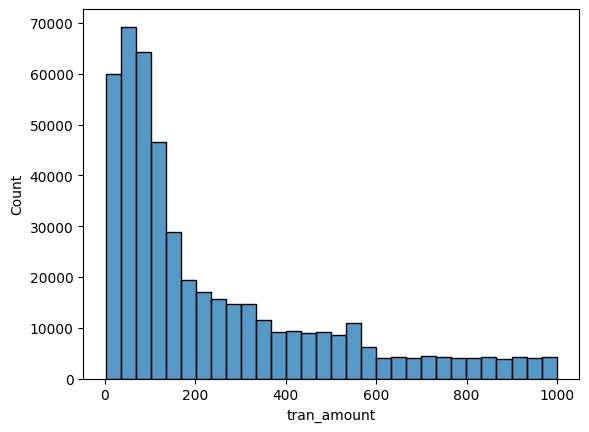

In [72]:
sns.histplot(df_trans[df_trans['tran_amount']<10000].tran_amount,bins=30)
plt.show()

In [73]:
q1, q3 = df_trans['tran_amount'].quantile([0.25,0.75])
IQR = q3 -q1
lower = q1 - 2*IQR
upper = q3 + 2*IQR
lower, upper

(-628.0, 1107.0)

In [74]:
df_trans_outliers = df_trans[df_trans['tran_amount'] > 1107.0]
df_trans_outliers.shape

(25000, 7)

In [75]:
df_trans_normal = df_trans[df_trans['tran_amount'] < 1107.0]
df_trans_normal.head()

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
0,1,705,2023-01-01,63,Flipkart,Electronics,Phonepe
1,2,385,2023-01-01,99,Alibaba,Fashion & Apparel,Credit Card
2,3,924,2023-01-01,471,Shopify,Sports,Phonepe
3,4,797,2023-01-01,33,Shopify,Fashion & Apparel,Gpay
4,5,482,2023-01-01,68,Amazon,Fashion & Apparel,Net Banking


In [76]:
mean_to_replace = df_trans_normal.groupby('product_category')['tran_amount'].mean()
mean_to_replace

product_category
Beauty & Personal Care     92.167205
Books                      29.553515
Electronics               510.172685
Fashion & Apparel          64.553463
Garden & Outdoor          125.630277
Home Decor                302.487561
Kitchen Appliances        176.773288
Sports                    269.181631
Toys & Games               50.333298
Name: tran_amount, dtype: float64

In [77]:
df_trans.loc[df_trans_outliers.index, 'tran_amount'] = df_trans_outliers['product_category'].map(mean_to_replace)

In [78]:
df_trans.loc[df_trans_outliers.index]

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type
26,27,380,2023-01-01,92.167205,Shopify,Beauty & Personal Care,Credit Card
49,50,287,2023-01-01,50.333298,Amazon,Toys & Games,Gpay
94,95,770,2023-01-01,176.773288,Ebay,Kitchen Appliances,Credit Card
104,105,549,2023-01-01,64.553463,Flipkart,Fashion & Apparel,Gpay
113,114,790,2023-01-01,176.773288,Shopify,Kitchen Appliances,Credit Card
...,...,...,...,...,...,...,...
499742,499743,868,2023-09-05,64.553463,Meesho,Fashion & Apparel,Gpay
499888,499889,614,2023-09-05,64.553463,Meesho,Fashion & Apparel,Net Banking
499900,499901,811,2023-09-05,269.181631,Flipkart,Sports,Debit Card
499966,499967,662,2023-09-05,269.181631,Meesho,Sports,Gpay


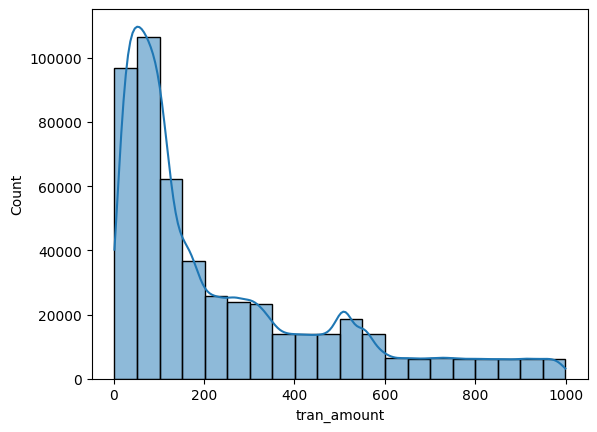

In [79]:
sns.histplot(df_trans[df_trans['tran_amount']<10000].tran_amount,bins=20,kde=True)
plt.show()

#### Insights:
- Right-Skewed Distribution: The distribution of transaction amounts is right-skewed, with the majority of transactions being of smaller amounts.

- High Frequency of Small Transactions: The highest frequency of transactions is within the lower range, particularly between 0 and 100.

### Data Visualization: Transactions Table

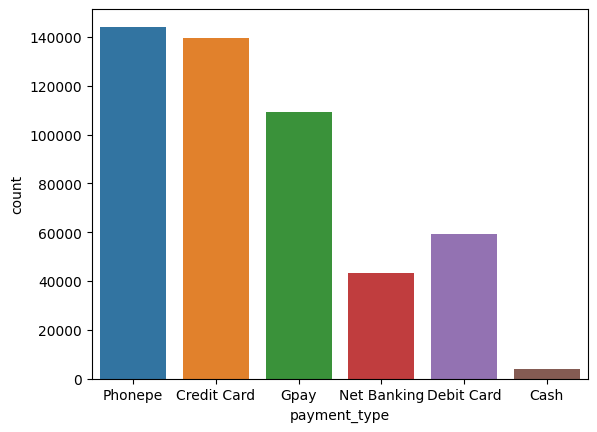

In [80]:
sns.countplot(x=df_trans.payment_type,palette = 'tab10')
plt.show()

#### Insights
- PhonePe is the most widely used payment method, indicating a strong preference for UPI-based mobile wallets among customers.
- Credit Card usage closely follows PhonePe, suggesting that a significant portion of users still rely on traditional credit based transactions , possibly for benefits like EMI options or reward points.
- GPay holds a solid third position, further confirming the growing adoption of UPI and mobile-first payment solutions.
- Debit Cards (11.9%) and Net Banking (8.6%) are used less frequently, showing that customers are increasingly shifting away from conventional banking methods for online purchases.
- Cash is almost negligible, underscoring a near-complete shift toward digital payments.

In [81]:
df_merge = pd.merge(df_trans, df_cust, on = 'cust_id', how = 'inner')
df_merge.sample(3)

,tran_id,cust_id,tran_date,tran_amount,platform,product_category,payment_type,name,gender,age,location,occupation,annual_income,marital_status,age_group
325676,325677,486,2023-06-11,72.0,Amazon,Beauty & Personal Care,Credit Card,Aahan Batra,Male,53,City,Business Owner,415191.0,Married,49-65
293747,293748,142,2023-05-26,158.0,Flipkart,Electronics,Gpay,Suhani Raj,Female,19,City,Freelancer,43235.0,Married,18-25
98844,98845,346,2023-02-18,8.0,Amazon,Toys & Games,Gpay,Sara Dhawan,Female,29,City,Fullstack Developer,99499.0,Single,26-48


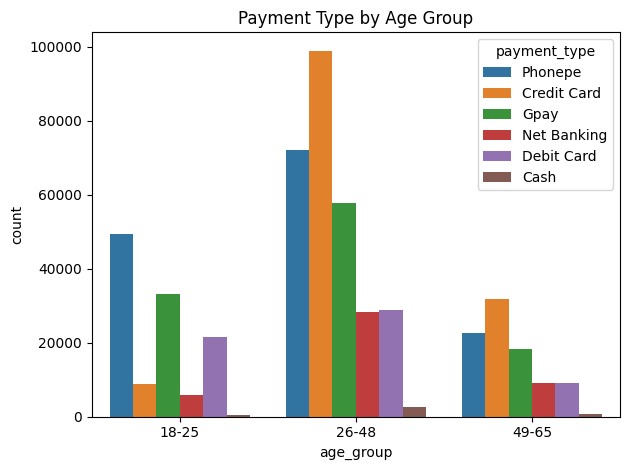

In [83]:
sns.countplot(data=df_merge, x='age_group', hue='payment_type')
plt.title('Payment Type by Age Group')
plt.tight_layout()
plt.show()

#### Insights
- Age Group 18–25 relies more on UPI payments, especially PhonePe and GPay indicating a preference for digital payment methods. Credit Card usage is lowest here, likely due to limited credit access or lower income eligibility.
- Age Group 26–48 shows the highest transaction volume across all payment methods, reflecting this segment's dominance in digital and card-based transactions. Credit Card usage is most prominent in this group, indicating higher financial maturity and purchasing power.
- Age Group 49–65 shows moderate preference toward Credit Card and PhonePe, but overall transaction volume is lower than younger groups.
- Overall, digital payment methods like Phonepe and Gpay are popular among younger age groups, while Credit Card usage is high across all age groups, particularly in the 26-48 range.Age group 18-25 has less exposure to credit cards compared to other groups.

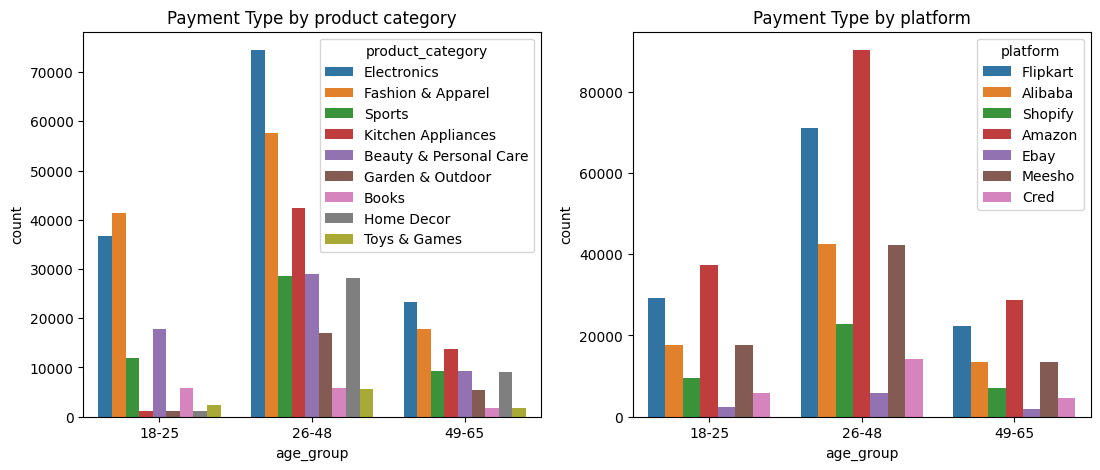

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(13,5))
ax1 = sns.countplot(data=df_merge, x='age_group', hue='product_category', ax = ax1)
ax1.set_title('Payment Type by product category')

ax2 = sns.countplot(data=df_merge, x='age_group', hue='platform', ax = ax2)
ax2.set_title('Payment Type by platform')
plt.show()

#### Insights
### Product Category Preferences by Age Group

- Age Group 18–25 shows strong interest in Fashion & Apparel, Electronics, Beauty & Personal Care. These trends reflect youth-driven shopping behaviors focused on tech, lifestyle, and personal grooming.
- Age Group 26–48 dominates across most product categories, especially in Electronics, Fashion & Apparel, Kitchen Appliances, Home Decor. This group represents the most active and diverse segment of shoppers.
- Age Group 49–65 contributes less in volume but still engages in Electronics, Fashion & Apparel, Home Decor
### Platform Usage by Age Group

- Amazon is the leading platform across all age groups — especially dominant among 26–48 users.
- Flipkart and Alibaba are strong alternatives, particularly for the 26–48 and 18–25 groups.
- Meesho sees noticeable activity in 18–25 and 26–48, likely due to its budget-friendly, trend-driven product range.
- Shopify and Cred are more active in the 26–48 segment, indicating a skew toward entrepreneurial or premium consumer behavior.
- Ebay has minimal usage.

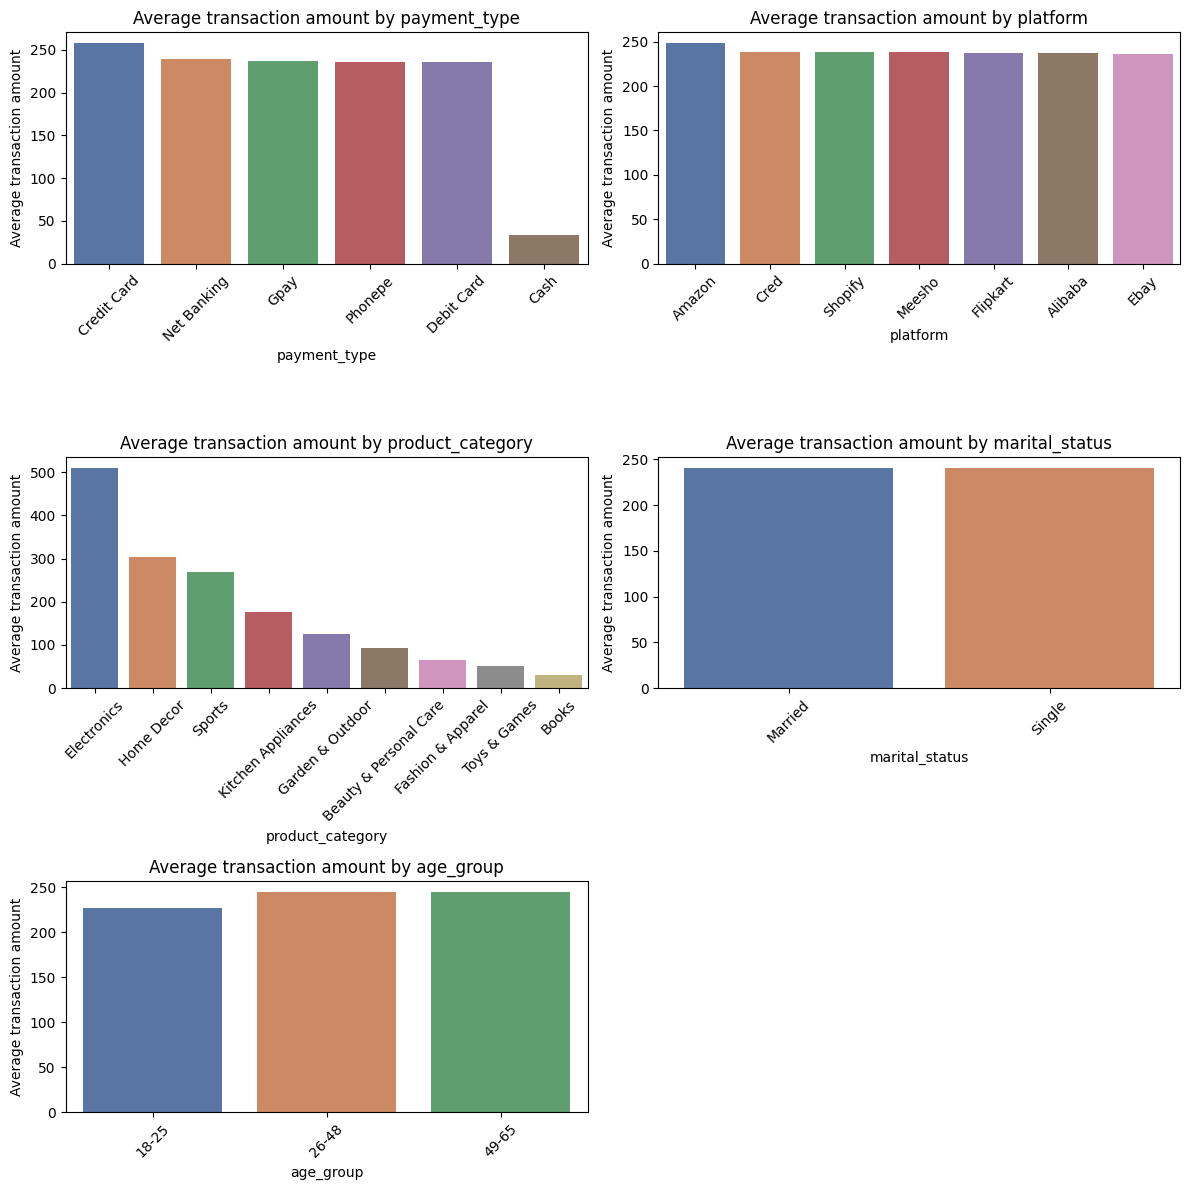

In [86]:
# List of categorical columns
cat_cols = ['payment_type', 'platform', 'product_category', 'marital_status', 'age_group']

num_rows = 3
# Create subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 4 * num_rows))

# Flatten the axes array to make it easier to iterate
axes = axes.flatten()

# Create subplots for each categorical column
for i, cat_col in enumerate(cat_cols):
    # Calculate the average transaction amount for each category
    avg_tran_amount_by_category = df_merge.groupby(cat_col, observed=True)['tran_amount'].mean().reset_index()
    
    # Sort the data by 'tran_amount' before plotting
    sorted_data = avg_tran_amount_by_category.sort_values(by='tran_amount', ascending=False)
    
    sns.barplot(
        x=cat_col,
        y='tran_amount',
        hue=cat_col,                    # Fix for palette warning
        data=sorted_data,
        errorbar=None,                  # Fix for deprecated ci=None
        ax=axes[i],
        palette='deep',
        legend=False                    # Optional: removes duplicated legend entries
    )
    
    axes[i].set_title(f'Average transaction amount by {cat_col}')
    axes[i].set_xlabel(cat_col)
    axes[i].set_ylabel('Average transaction amount')

    # Safer way to rotate x-axis labels
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [87]:
# Group the data by age group and calculate the average credit_limit and credit_score

age_group_metrics = df_merged.groupby('age_group', observed = True)[['annual_income', 'credit_limit', 'credit_score']].mean().reset_index()
age_group_metrics

,age_group,annual_income,credit_limit,credit_score
0,18-25,36223.091667,886.458333,482.216667
1,26-48,145810.577990,20597.053726,598.176776
2,49-65,258530.874317,41729.508197,701.103825


In [88]:
df_merged.columns

Index(['cust_id', 'credit_score', 'credit_utilisation', 'outstanding_debt',
       'credit_inquiries_last_6_months', 'credit_limit', 'credit_score_range',
       'credit_limit_mode', 'name', 'gender', 'age', 'location', 'occupation',
       'annual_income', 'marital_status', 'age_group'],
      dtype='object')

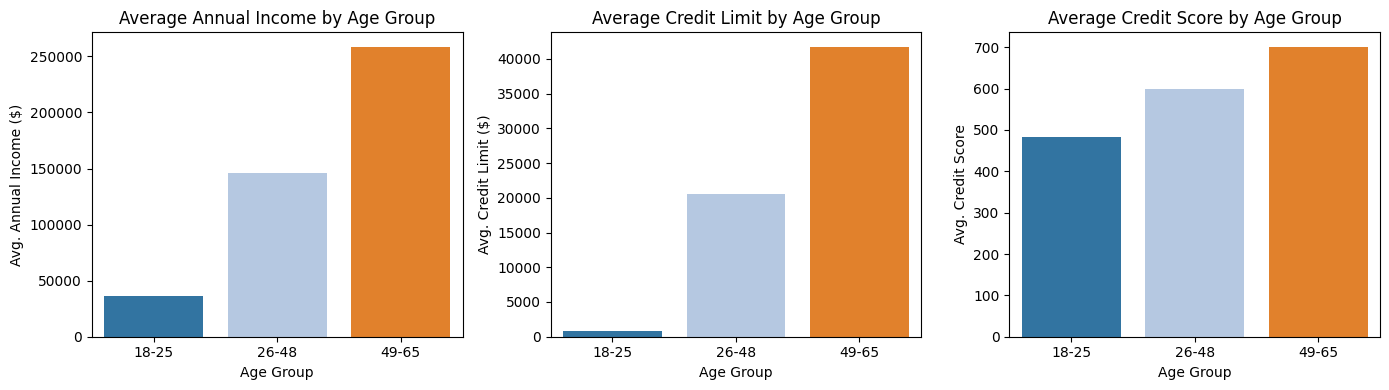

In [89]:
# Create subplots (3 horizontal charts)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))

# Plot 1: Average annual income
sns.barplot(x='age_group', y='annual_income', data=age_group_metrics, hue='age_group', palette='tab20', ax=ax1, legend=False)
ax1.set_title('Average Annual Income by Age Group')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Avg. Annual Income ($)')
ax1.tick_params(axis='x', rotation=0)

# Plot 2: Average credit limit
sns.barplot(x='age_group', y='credit_limit', data=age_group_metrics, hue='age_group', palette='tab20', ax=ax2, legend=False)
ax2.set_title('Average Credit Limit by Age Group')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Avg. Credit Limit ($)')
ax2.tick_params(axis='x', rotation=0)

# Plot 3: Average credit score
sns.barplot(x='age_group', y='credit_score', data=age_group_metrics, hue='age_group', palette='tab20', ax=ax3, legend=False)
ax3.set_title('Average Credit Score by Age Group')
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Avg. Credit Score')
ax3.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

<h4 style="color:blue">Finalize Target Market For a Trail Credit Card Launch</h4>

#### Insights for the Age Group 18–25
Customer Base Share:
- Individuals aged 18–25 account for ~24.6% of the total customer base.

Income & Financial Background:
- The average annual income is below $50,000, indicating limited earning capacity.
- This age group shows limited credit history, as reflected in their low credit scores and modest credit limits.

Spending & Card Behavior:
- Credit card usage is relatively low compared to older age groups. Likely due to a combination of income level and lack of prior credit experience.

Top Spending Categories:
The most popular product categories among this group are:

1. Electronics
2. Fashion & Apparel
3. Beauty & Personal Care

These categories suggest a high interest in lifestyle and aspirational spending, despite limited financial leverage.

<h2 align="center" style="color:purple">Phase 2: AtliQ0 Bank Credit Card Project</h2>

<h4 style="color:blue">In the Phase 2 of project, Business Analysis and launch of AB testing</h4>

#### Pre-Campaign
To conduct a trial run for the new credit card, it is necessary to determine the number of customers required for A/B testing. This involves forming both a control and a test group. The number of customers in each group will be based on the agreed-upon statistical power and effect size, following discussions with the business team.

In [92]:
# Define parameters for power analysis

alpha = 0.05
power = 0.8
effect_size=0.2

sms.tt_ind_solve_power(
    effect_size=0.2, 
    alpha=alpha, 
    power=power, 
    ratio=1, 
    alternative='two-sided'
)

393.40569300025135

For an effect size of 0.2, a sample of 393 customers is required. However, considering potential budget constraints, it would be prudent to evaluate sample size requirements across multiple effect sizes. This will allow us to have an informed discussion with the business team and determine the most cost-effective and statistically appropriate sample size for the campaign.

In [93]:
# Calculate the required sample size for different effect sizes
effect_sizes = [0.1, 0.2, 0.3, 0.4, 0.5,1]  #  standard deviations greater than control group 

for effect_size in effect_sizes:
    sample_size = sms.tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1, alternative='two-sided')
    print(f"Effect Size: {effect_size}, Required Sample Size: {int(sample_size)} customers")

Effect Size: 0.1, Required Sample Size: 1570 customers
Effect Size: 0.2, Required Sample Size: 393 customers
Effect Size: 0.3, Required Sample Size: 175 customers
Effect Size: 0.4, Required Sample Size: 99 customers
Effect Size: 0.5, Required Sample Size: 63 customers
Effect Size: 1, Required Sample Size: 16 customers


Based on the business requirements, the test should be designed to detect a minimum effect size of 0.4 standard deviations between the control and test groups. For this effect size, a sample size of 100 customers is required. After discussions with the business team, it was confirmed that 100 customers aligns with their budget constraints for this trial run.

#### Insights
- Customer Selection: From a pool of approximately 246 customers aged 18 to 25, a subset of 100 customers was selected for the initial campaign launch.

- Campaign Design: The campaign was executed with 100 customers in the test group, based on effect size calculations and budget considerations. The campaign was scheduled to run for a duration of 2 months.

- Test Group Response: The campaign achieved a conversion rate of ~40%, meaning that 40 out of 100 customers in the test group started using the newly launched credit card.

- Control Group Formation: To maintain statistical balance, a control group of 40 customers was established. These individuals were completely separate from the 100 customers in the test group.

- AB Test Setup: As a result, both test and control groups consist of 40 customers each.

- Post-Campaign Evaluation: At the end of the 2-month period, daily transaction data was collected to compare the average transaction amounts between the control group (using existing credit cards) and the test group (using the newly launched credit card).

- KPI Focus: The primary KPI for this A/B test is to assess whether the new credit card improves the average transaction value among customers.

### Post-Campaign

In [94]:
# Loading campaign results data
df = pd.read_csv('avg_transactions_after_campaign.csv')
df.head(4)

,campaign_date,control_group_avg_tran,test_group_avg_tran
0,2023-09-10,259.83,277.32
1,2023-09-11,191.27,248.68
2,2023-09-12,212.41,286.61
3,2023-09-13,214.92,214.85


In [95]:
df.shape

(62, 3)

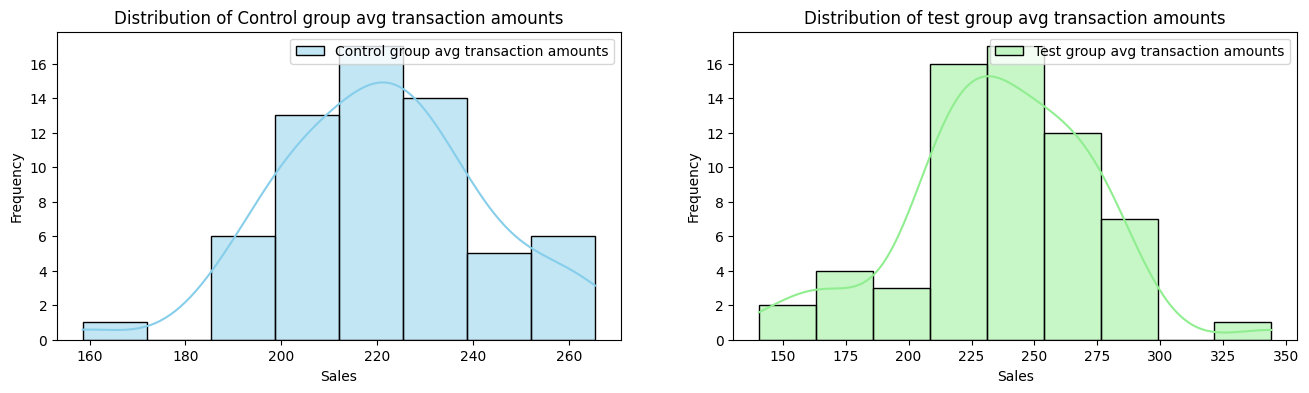

In [96]:
# Let's look at distributions of avg transactions amounts in both groups
# Create a 1x2 grid of subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# Plot the distribution of Campaign A Sales
sns.histplot(df['control_group_avg_tran'], kde=True, color='skyblue', label='Control group avg transaction amounts', ax=ax1)
ax1.set_xlabel('Sales')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Control group avg transaction amounts')
ax1.legend(loc='upper right')

# Plot the distribution of Campaign B Sales
sns.histplot(df['test_group_avg_tran'], kde=True, color='lightgreen', label='Test group avg transaction amounts', ax=ax2)
ax2.set_xlabel('Sales')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of test group avg transaction amounts')
ax2.legend(loc='upper right')

# Show the plots
plt.show()

#### Hypotheses:
- Null Hypothesis (H0): The new credit card does not significantly increase the usage or transaction amounts compared to the existing credit card.

- Alternative Hypothesis (H1): The new credit card significantly increases the usage or transaction amounts compared to the existing credit card.

#### Perform Hypothesis Testing Using Two Sample Z-test

In [98]:
# Calculate the mean and standard deviation of the control group's average transactions
control_mean = float(df["control_group_avg_tran"].mean())
control_std = float(df["control_group_avg_tran"].std())
control_mean, control_std

(221.1751612903226, 21.35919211202701)

In [99]:
# Calculate the mean and standard deviation of the test group's average transactions
test_mean = float(df["test_group_avg_tran"].mean())
test_std = float(df["test_group_avg_tran"].std())
test_mean, test_std

(235.9835483870968, 36.658082109186374)

In [100]:
# Calculate the sample size by getting the number of rows in the dataset
sample_size = df.shape[0]
sample_size

62

#### Test Using Rejection Region (Critical Z Value)

In [102]:
# Calculate the variance divided by the sample size for both control and test groups
a = (control_std**2/sample_size)
b = (test_std**2/sample_size)

# Calculate the Z-score for the difference in means between the test and control groups
Z_score = (test_mean-control_mean)/np.sqrt(a+b)
float(Z_score)

2.748297374569113

In [103]:
# For a significance level of 5% (0.05) in a right-tailed test, the critical Z-value is approximately 1.645
critical_z_value = st.norm.ppf(1 - alpha)  # Right-tailed test at 5% significance level
float(critical_z_value)

1.6448536269514722

In [104]:
# Compare the calculated Z-score with the critical Z-value to determine statistical significance
Z_score > critical_z_value

np.True_

#### Insights
- Since Z score is higher than critical Z value, we can reject the null hypothesis.

#### Test Using p-Value

In [106]:
# Calculate the p-value corresponding to z score for a right-tailed test
p_value = 1 - st.norm.cdf(Z_score)
float(p_value)

0.0029952824622024865

In [107]:
p_value < alpha # p value is less than significance level of 5% (or 0.05 for absolute value)

np.True_

Since p value is less than significance level (i.e. alpha), we can reject the null hypothesis.

#### Using Ready Made API call

In [108]:
# Performing Z-test with above considerations
z_statistic, p_value = sm.stats.ztest( df['test_group_avg_tran'],df['control_group_avg_tran'],alternative = 'larger')
z_statistic, p_value

(np.float64(2.7482973745691135), np.float64(0.002995282462202502))

#### Conclusion
- Statistical Significance, Since the p-value (0.003) is well below the common significance level of 0.05, we reject the null hypothesis. This indicates a statistically significant difference between the test group and the control group.
- The new credit card offering in the test group had a positive impact, leading to higher average transaction amounts. This suggests that the campaign or card features may be effectively influencing spending behavior.
- Based on this result, the campaign appears to be successful.